In [1]:
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.svm import SVR,SVC,NuSVC
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from IPython import display
from sklearn.manifold import TSNE
import os

%matplotlib inline


# Это финальная версия, в которой оставлен только код, используемый в обработке видео с помощью SVM

# подгружаем датасет с небом

In [2]:
import kagglehub

# Download latest version
path_skyimage = kagglehub.dataset_download("antigs/skyimage-dataset")

print("Path to dataset files:", path_skyimage)

C:\Users\fedbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\fedbe\.cache\kagglehub\datasets\antigs\skyimage-dataset\versions\1


# читаем снимки из папки, параллельно создаем вектор HOG - фичей. Именно его и будем использовать

In [3]:
def process_images_from_folder_HOG_only_gr(folder_path):
    image_vectors = []
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        try:
            image = imread(file_path)
            image = cv2.resize(image, (64,64))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )
            #print(image.ravel().shape)
            fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)
            #d = np.concatenate(image.ravel(),fd)
            d = np.array(fd)
            image_vectors.append(d)
        except Exception as e:
            print(f"Ошибка при обработке файла {file_name}: {e}")
            
    return image_vectors


In [4]:
view = {0 : 'Far', 1 : 'Left', 2 : 'MiddleClose', 3 : 'Right'}
path = './OwnCollection/non-vehicles/'
res_non_vehicle_HOG = []
for cls in view:
    path_using = path + view[cls] + '/'
    res_non_vehicle_HOG += process_images_from_folder_HOG_only_gr(path_using)
#res_non_vehicle_HOG

In [5]:
np.array(res_non_vehicle_HOG).shape

(3900, 1764)

In [6]:
res_non_vehicle_HOG += process_images_from_folder_HOG_only_gr(path_skyimage + '\\swimseg-2\\train')

In [7]:
np.array(res_non_vehicle_HOG).shape

(4761, 1764)

In [8]:
import random
random.shuffle(res_non_vehicle_HOG)
res_non_vehicle_HOG = res_non_vehicle_HOG[:3500]
np.array(res_non_vehicle_HOG).shape

(3500, 1764)

In [9]:
view = {0 : 'Far', 1 : 'Left', 2 : 'MiddleClose', 3 : 'Right'}
path = './OwnCollection/vehicles/'
res_vehicle_HOG = []
for cls in view:
    path_using = path + view[cls] + '/'
    res_vehicle_HOG += process_images_from_folder_HOG_only_gr(path_using)
#res_vehicle_HOG


In [10]:
res_non_vehicle_HOG = np.array(res_non_vehicle_HOG)
res_vehicle_HOG = np.array(res_vehicle_HOG)

In [11]:
res_vehicle_HOG.shape

(3425, 1764)

In [12]:
y = np.concatenate((np.ones(res_vehicle_HOG.shape[0]), np.zeros(res_non_vehicle_HOG.shape[0])))

In [13]:
X = np.vstack((res_vehicle_HOG, res_non_vehicle_HOG))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

(array([692.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 693.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

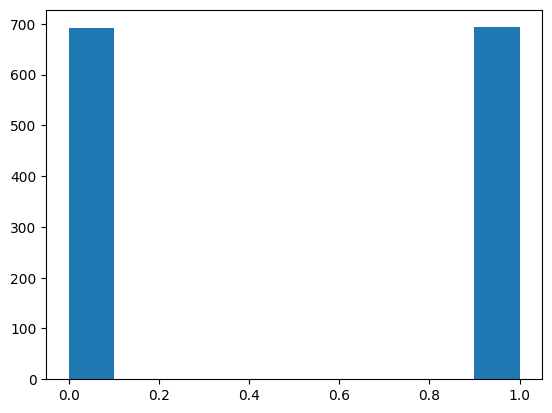

In [15]:
plt.hist(y_test)

(array([3500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3425.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

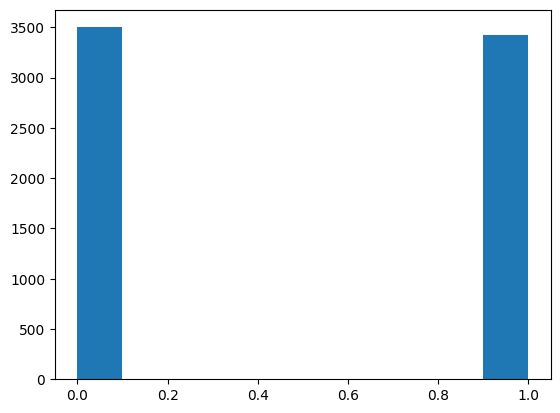

In [16]:
plt.hist(y)

In [17]:
model8 = SVC(kernel='rbf', gamma='scale', C = 5.0, probability=True)
model8.fit(X, y)

SVC(C=5.0, probability=True)

In [18]:
def metrics(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ac_score = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return cf_matrix, ac_score, prec, rec, f1

In [19]:
y_pred = model8.predict(X_test)

In [20]:
hog_metr = metrics(y_test, y_pred)

print(f"Accuracy Score with HOG features: {hog_metr[1]}")
print(f"Precision with HOG features: {hog_metr[2]}")
print(f"Recall with HOG features: {hog_metr[3]}")
print(f"F1 Score with HOG features: {hog_metr[4]}")

Accuracy Score with HOG features: 1.0
Precision with HOG features: 1.0
Recall with HOG features: 1.0
F1 Score with HOG features: 1.0


In [22]:
image_to_test = cv2.imread('./img2_to_test.jpg')
image_to_test = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2RGB)
image_gr = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2GRAY)

In [23]:
def sliding_window(image, window, step):
    for y in range(0, image.shape[0] - window[1], step):
        for x in range(0, image.shape[1] - window[0], step):
            yield (x, y, image[y:y + window[1], x:x + window[0]])

In [24]:
(window_w, window_h) = (64,64)

# For using without SIFT

In [ ]:
def create_bbox(image_gr, image_rgb): # для одного размера окошка
    heatmap = np.zeros((720,1280))
    for (x, y, window) in sliding_window(image_gr, (window_w, window_h), 20):
        if window.shape[0] != window_w or window.shape[1] != window_h:
            continue
        
        clone = image_gr.copy()
        inside = clone[y:y + window_h, x:x + window_w]
        im = cv2.resize(inside, (64,64))
        fd,_ = hog(im, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)
    
        pred = model8.predict_proba([fd])
        if pred[0][1] > 0.95:
            heatmap[y:y + window_w, x:x + window_w] += 10*pred[0][1]
    ret, thresh1 = cv2.threshold(heatmap, 150, 255, cv2.THRESH_BINARY) 
    contours, hierarchy = cv2.findContours(thresh1.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image_rgb


In [41]:
def take_heatmap(image, model, window_w, window_h, step, weight, prob = 0.99): # строит heatmap, проходя одним окошком
    heatmap = np.zeros((720,1280))
    for (x, y, window) in sliding_window(image, (window_w, window_h), step):
        if window.shape[0] != window_w or window.shape[1] != window_h:
            continue
        
        clone = image.copy()
        inside = clone[y:y + window_h, x:x + window_w]
        im = cv2.resize(inside, (64,64))
        fd,_ = hog(im, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)
    
        pred = model.predict_proba([fd])
        if pred[0][1] > prob:
            heatmap[y:y + window_w, x:x + window_w] += weight
    return heatmap

In [ ]:
# np.max((heatmap70 / np.max(heatmap70) * 255).astype(np.uint64))

In [44]:
def func_3_wind(image, model): # 3 размера окошка. строит heatmap (3 шт) и складывает их, устанавливая разные threshold
    heatmap70 = np.zeros((720,1280))
    heatmap140 = np.zeros((720,1280))
    heatmap200 = np.zeros((720,1280))

    window_w, window_h, step, weight = 70, 70, 10, 10
    heatmap70 = take_heatmap(image, model, window_w, window_h, step, weight)

    window_w, window_h, step, weight = 140, 140, 35, 10
    heatmap140 = take_heatmap(image, model, window_w, window_h, step, weight)

    window_w, window_h,step, weight = 200, 200, 40, 10
    heatmap200 = take_heatmap(image, model, window_w, window_h, step, weight)

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    ax[0].imshow(heatmap70)
    ax[0].set_title('70')
    ax[0].grid()

    ax[1].imshow(heatmap140)
    ax[1].set_title('140')
    ax[1].grid()

    ax[2].imshow(heatmap200)
    ax[2].set_title('200')
    ax[2].grid()

    
    
    ret70, thresh70 = cv2.threshold(heatmap70, np.max(heatmap70) * 0.6, 255, cv2.THRESH_BINARY) 
    ret140, thresh140 = cv2.threshold(heatmap140, np.max(heatmap140) * 0.5, 120, cv2.THRESH_BINARY) 
    ret200, thresh200 = cv2.threshold(heatmap200, np.max(heatmap200) * 0.8, 180, cv2.THRESH_BINARY) 

    fig2, ax2 = plt.subplots(1, 3, figsize=(15, 15))
    
    ax2[0].imshow(thresh70)
    ax2[0].set_title('70')
    ax2[0].grid()

    ax2[1].imshow(thresh140)
    ax2[1].set_title('140')
    ax2[1].grid()

    ax2[2].imshow(thresh200)
    ax2[2].set_title('200')
    ax2[2].grid()

    plt.show()

    heatmap_sum = thresh200 + thresh140 + thresh70
    ret, thresh_sum = cv2.threshold(heatmap_sum, np.max(heatmap_sum)*0.4, 255, cv2.THRESH_BINARY) 
    return thresh_sum

In [45]:
def bbox_for_3_wind(image_gr, image_rgb, model): # строит bounding box по трем окошкам
    heatmap = np.zeros((720,1280))
    thresh_3w = func_3_wind(image_gr, model)

    contours, hierarchy = cv2.findContours(thresh_3w.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image_rgb, thresh_3w


In [101]:
image_to_test = cv2.imread('./img1_to_test.jpg')
image_to_test = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2RGB)
image_gr = cv2.cvtColor(image_to_test, cv2.COLOR_BGR2GRAY)

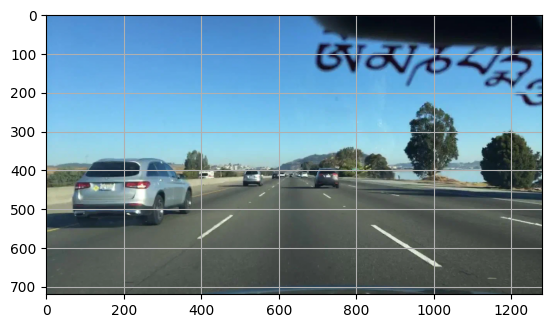

In [102]:
plt.imshow(image_to_test)
plt.grid()

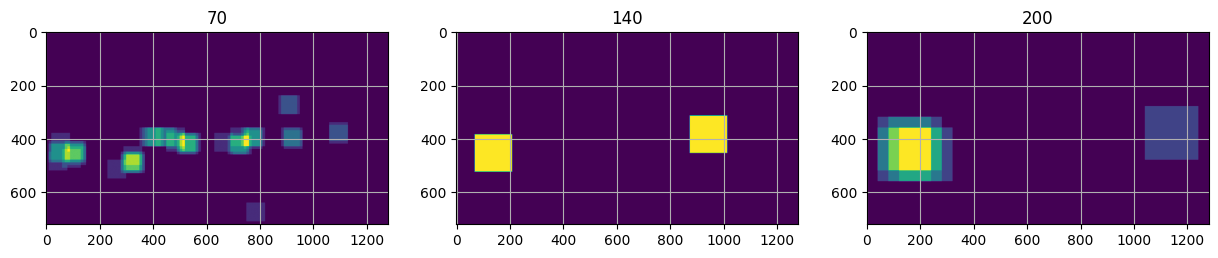

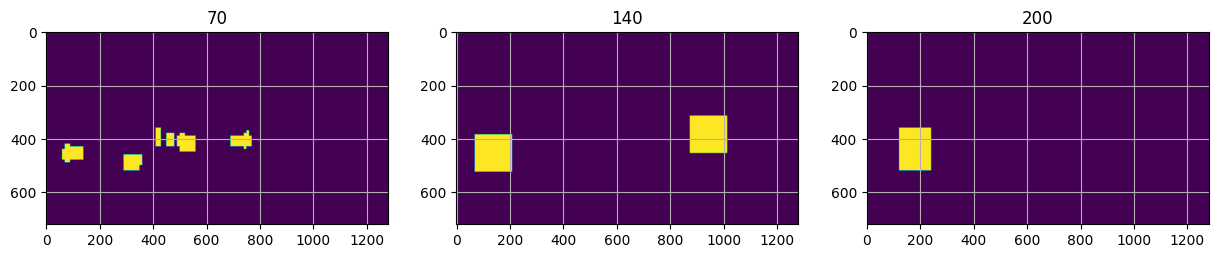

CPU times: total: 32 s
Wall time: 59.7 s


In [103]:
%%time
img_boxes, img_tr = bbox_for_3_wind(image_gr.copy(), image_to_test.copy(), model8)

C:\Users\fedbe\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


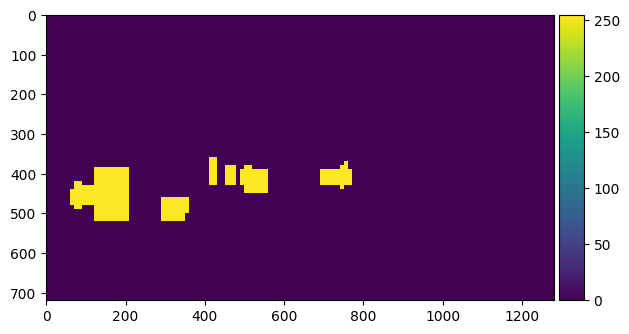

In [104]:
imshow(img_tr)

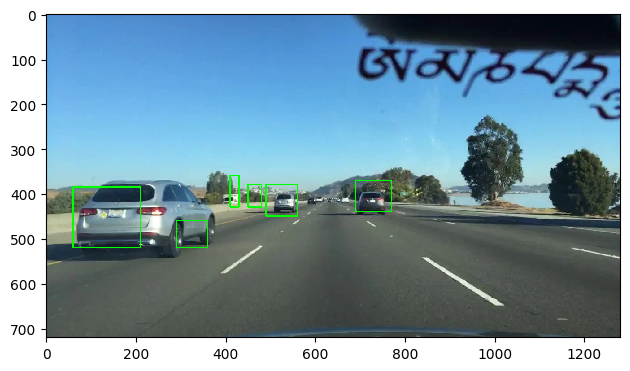

In [105]:
imshow(img_boxes)

# Для обработки видео:

In [ ]:
# filename = './SanFrancisco_cut.mp4'
# cap = cv2.VideoCapture(filename)

# framesize = (int(1280), int(720))
# fourcc = cv2.VideoWriter.fourcc(*'XVID')
# out = cv2.VideoWriter(f"SF_3_bbox.avi", fourcc, 30.0, framesize, isColor=True)

# if (cap.isOpened()== False): 
#   print("Error opening video stream or file")
    
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret == True:
#         img_gr = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         frame = bbox_for_3_wind(img_gr,frame)
#         out.write(frame)
    
#     else: 
#         break
 
# cap.release()
# cv2.destroyAllWindows()
